<a href="https://colab.research.google.com/github/AnaClaudiaMessias/Fairness_ML/blob/main/Fairness_em_Aprendizado_de_M%C3%A1quina_vi%C3%A9s_racial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando biblotecas e dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
# Caminho para o arquivo CSV no Google Drive
caminho_arquivo_csv = '/content/drive/MyDrive/tfc/PNAD 2015/pnad.pes_2015.csv'

# Abrir o arquivo CSV usando o pandas
df = pd.read_csv(caminho_arquivo_csv, delimiter='\t')

# Exibir o DataFrame
print(df.columns)

Index(['V0101', 'UF', 'V0102', 'V0103', 'V0301', 'V0302', 'V3031', 'V3032',
       'V3033', 'V8005',
       ...
       'V3629', 'V3630', 'V3631', 'V3632', 'V3633', 'V3634', 'V3637', 'V3638',
       'V9993', 'domicilioid'],
      dtype='object', length=436)


## Análise de renda (percentil)

In [ ]:
df_com_renda = df[df["V4718"].notna()]

In [ ]:
percentil_70 = df['V4718'].quantile(0.70)
print(f"Percentil 70% da renda: {percentil_70}")

Percentil 70% da renda: 1500.0


## Tratando os dados

In [ ]:
# 2 == branca
# 4 == preta
# 6 == amarela
# 8 == parda
# 0 == indigena
# 9 == sem_declaracao

# transformar variável sensível em binária
df['V0404'] = df['V0404'].replace({2: 1, 6: 1, 4: 0, 8: 0, 9:None})

# 1,2,3 == zona rural
# 4, 5, 6, 7, 8 == zona urbana

# transformar variável em binária
df['V4728 '] = df['V4728'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})

#df['renda_binaria'] =
df.loc[df['V4718'] <= 1500, 'renda_binaria'] = 0
#df['renda_binaria'] =
df.loc[df['V4718'] > 1500, 'renda_binaria'] = 1

df = df.rename(columns={"UF": "V0000"})

# selecionar features
dados = ['V4803', 'V6007', 'V4011', 'V0000', 'V4707', 'V0302','V4809', 'V4810', 'V8005', 'V9042', 'V4706', 'V0404', 'V9032', 'V4728', 'renda_binaria']

# Exibir o DataFrame tratado
print(df[dados].head(16))

    V4803  V6007  V4011  V0000  V4707  V0302  V4809  V4810  V8005  V9042  \
0      12    5.0    0.0     11    3.0      2   11.0    5.0     23    4.0   
1      12    5.0    5.0     11    3.0      4   12.0    4.0     23    2.0   
2      15    NaN    NaN     11    3.0      4    8.0    2.0     35    4.0   
3      15    8.0    NaN     11    5.0      2    5.0    1.0     34    NaN   
4       4    NaN    0.0     11    NaN      4    NaN    NaN     11    NaN   
5       2    NaN    NaN     11    NaN      4    NaN    NaN      7    NaN   
6       1    NaN    NaN     11    NaN      4    NaN    NaN      4    NaN   
7      12    5.0    0.0     11    3.0      4    5.0    4.0     18    2.0   
8       6    4.0    0.0     11    5.0      2    7.0    8.0     46    NaN   
9       3    1.0    7.0     11    NaN      4    NaN    NaN     81    NaN   
10      6    4.0    5.0     11    NaN      4    NaN    NaN     71    NaN   
11      9    4.0    1.0     11    3.0      4   10.0    5.0     47    4.0   
12     12   

In [ ]:
# tratar os dados

# fazer drop NaN para não ter dado nulo
df = df[dados].dropna()

# Criar uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Normalizar as duas colunas
df[dados] = scaler.fit_transform(df[dados])

# Exibir o DataFrame tratado
print(df[dados].head(16))

       V4803     V6007     V4011  V0000  V4707  V0302     V4809     V4810  \
0   0.733333  0.333333  0.000000    0.0   0.50    0.0  0.833333  0.444444   
1   0.733333  0.333333  0.714286    0.0   0.50    1.0  0.916667  0.333333   
7   0.733333  0.333333  0.000000    0.0   0.50    1.0  0.333333  0.333333   
16  0.733333  0.333333  0.142857    0.0   0.50    1.0  0.333333  0.555556   
17  0.733333  0.333333  0.142857    0.0   0.50    0.0  0.250000  0.777778   
18  0.533333  0.250000  0.000000    0.0   1.00    0.0  0.416667  0.555556   
26  1.000000  0.583333  0.000000    0.0   0.50    1.0  0.666667  0.111111   
27  0.733333  0.333333  0.142857    0.0   0.50    0.0  0.166667  0.000000   
28  0.666667  0.333333  0.142857    0.0   0.50    1.0  0.333333  0.555556   
36  0.266667  0.250000  0.000000    0.0   1.00    0.0  0.083333  0.777778   
42  0.733333  0.333333  0.000000    0.0   0.50    0.0  0.333333  0.555556   
43  0.733333  0.333333  0.000000    0.0   0.50    1.0  0.666667  0.444444   

In [ ]:
'''
Legenda:

anos de estudo == df['V4803']
Curso mais elevado que frequentou anteriormentedf == ['V6007']
Estado civil == df['V4011']
UF == df['V0000']
faixa de horas de trabalho semanal == df['V4707']
gênero == df['V0302']
grupamento de atividade do empreendimento do trabalho == df['V4809']
grupamento ocupacionais do trabalho == df['V4810']
idade  == df['V8005']
tinha carteira de trabalho assinada no trabalho principal da semana de referência == df['V9042']
posição no trabalho == df['V4706']
raça == df['V0404']
Setor do emprego no trabalho principal da semana de referência == df['V9032']
situação censitária == df['V4728']
renda binária == df['renda_binaria']

'''

"\nLegenda:\n\nanos de estudo == df['V4803']\nCurso mais elevado que frequentou anteriormentedf == ['V6007']\nEstado civil == df['V4011']\nUF == df['V0000']\nfaixa de horas de trabalho semanal == df['V4707']\ngênero == df['V0302']\ngrupamento de atividade do empreendimento do trabalho == df['V4809']\ngrupamento ocupacionais do trabalho == df['V4810']\nidade  == df['V8005']\ntinha carteira de trabalho assinada no trabalho principal da semana de referência == df['V9042']\nposição no trabalho == df['V4706']\nraça == df['V0404']\nSetor do emprego no trabalho principal da semana de referência == df['V9032']\nsituação censitária == df['V4728']\nrenda binária == df['renda_binaria']\n\n"

In [ ]:
# Separar as variáveis independentes (atributos) e a variável dependente (target)
y = df[dados]['renda_binaria']
X = df[dados].drop(['renda_binaria'], axis=1)

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_priv = X_test[X_test['V0404']==1]
y_test_priv = y_test[X_test['V0404']==1]
X_priv_invert = X_test_priv.replace({0: 1})

print(X_test_priv)
print(y_test_priv)

           V4803     V6007  V4011     V0000  V4707  V0302     V4809     V4810  \
307595  0.733333  0.333333    0.0  0.761905   0.50    0.0  0.166667  0.777778   
28425   0.733333  0.333333    0.0  0.095238   0.50    1.0  0.833333  0.444444   
347080  0.666667  0.333333    0.0  0.976190   0.50    0.0  0.166667  0.777778   
14723   0.866667  0.583333    0.0  0.047619   1.00    1.0  0.166667  0.555556   
2624    0.133333  0.250000    0.0  0.000000   0.50    0.0  0.333333  0.444444   
...          ...       ...    ...       ...    ...    ...       ...       ...   
311021  1.000000  0.583333    1.0  0.761905   0.25    1.0  0.666667  0.111111   
274646  1.000000  0.666667    0.0  0.714286   1.00    1.0  0.333333  0.000000   
272848  0.733333  0.333333    0.0  0.714286   0.50    0.0  0.166667  0.000000   
41739   0.000000  0.000000    0.0  0.095238   0.75    0.0  0.250000  0.777778   
233259  0.733333  0.333333    0.0  0.571429   0.50    1.0  0.916667  0.444444   

           V8005  V9042  V4

## Criar e treinar modelos

In [ ]:
# Criar os modelos
regressao_logistica = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.1)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb_classifier = XGBClassifier(reg_alpha=1.0, random_state=42)

# Treinar os modelos usando os dados de treinamento
regressao_logistica.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Regressão Logística


*   Grupo Privilegiado



Acurácia do modelo regressao_logistica: 0.78
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85      2603
         1.0       0.74      0.52      0.61      1287

    accuracy                           0.78      3890
   macro avg       0.77      0.72      0.73      3890
weighted avg       0.78      0.78      0.77      3890



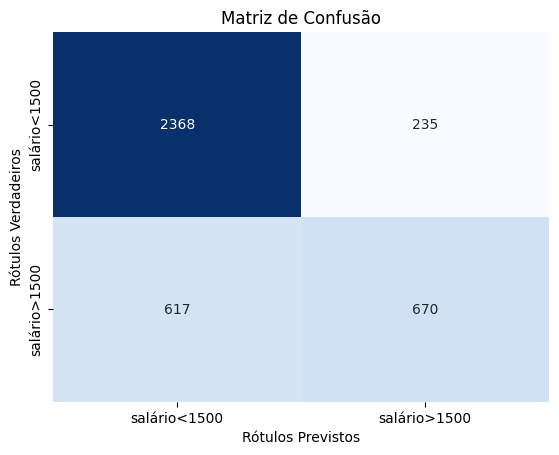

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_regressao_logistica = regressao_logistica.predict(X_test_priv)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_regressao_logistica = accuracy_score(y_test_priv, y_pred_regressao_logistica)
print(f'Acurácia do modelo regressao_logistica: {acuracia_regressao_logistica:.2f}')
print(classification_report(y_test_priv, y_pred_regressao_logistica ))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_priv, y_pred_regressao_logistica)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()



*   Grupo Desprivilegiado (rótulo = 0)



Acurácia do modelo regressao_logistica: 0.72
              precision    recall  f1-score   support

         0.0       0.72      0.94      0.82      2603
         1.0       0.70      0.28      0.40      1287

    accuracy                           0.72      3890
   macro avg       0.71      0.61      0.61      3890
weighted avg       0.72      0.72      0.68      3890



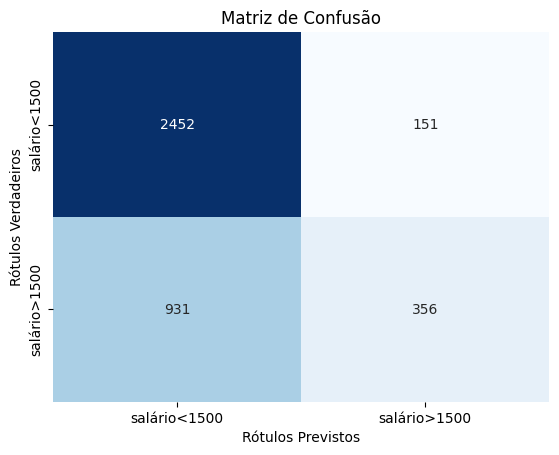

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_regressao_logistica = regressao_logistica.predict(X_priv_invert)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_regressao_logistica = accuracy_score(y_test_priv, y_pred_regressao_logistica)
print(f'Acurácia do modelo regressao_logistica: {acuracia_regressao_logistica:.2f}')
print(classification_report(y_test_priv, y_pred_regressao_logistica ))

# Calcular a matriz de confusão
cm_inv = confusion_matrix(y_test_priv, y_pred_regressao_logistica)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm_inv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()





*   Métrica de Fairness - Disparate Impact



In [ ]:
# Calcula o disparate impact P_desp/P_priv
disparate_impact = (cm_inv[0][1]+cm_inv[1][1]) / (cm[0][1]+cm[1][1])
print("Disparate Impact:", disparate_impact)

# Interpretação: valores abaixo de 0.8 podem indicar disparidade

Disparate Impact: 0.5602209944751381




*   Métrica de Fairness - Igualdade de Oportunidade (Equal Opportunity)





In [ ]:
import numpy as np

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo protegido (a=1)
TP_privilegiado = cm[1][1]
FN_privilegiado = cm[1][0]
TPR_privilegiado = TP_privilegiado / (TP_privilegiado + FN_privilegiado)

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo não protegido (a=0)
TP_nao_privilegiado = cm_inv[1][1]
FN_nao_privilegiado = cm_inv[1][0]
TPR_nao_privilegiado = TP_nao_privilegiado / (TP_nao_privilegiado + FN_nao_privilegiado)

# Calculando a diferença na TPR entre os grupos
equal_opportunity_regressao_logistica = TPR_privilegiado - TPR_nao_privilegiado

print(f'Diferença de Equal Opportunity Regressao logistica: {equal_opportunity_regressao_logistica:.4f}')


Diferença de Equal Opportunity Regressao logistica: 0.2440


## Random Forest





*   Grupo Privilegiado (rótulo = 1)



Acurácia do modelo: 0.80
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86      2603
         1.0       0.80      0.52      0.63      1287

    accuracy                           0.80      3890
   macro avg       0.80      0.73      0.75      3890
weighted avg       0.80      0.80      0.79      3890



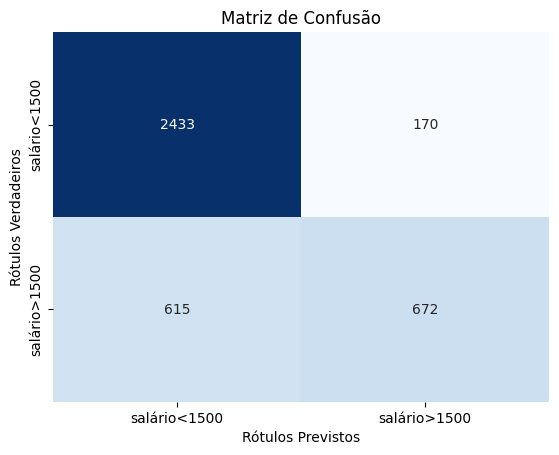

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_random_forest  = random_forest.predict(X_test_priv)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_random_forest = accuracy_score(y_test_priv, y_pred_random_forest)
print(f'Acurácia do modelo: {acuracia_random_forest:.2f}')
print(classification_report(y_test_priv, y_pred_random_forest ))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_priv, y_pred_random_forest)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

*   Grupo Desprivilegiado (rótulo = 0)

Acurácia do modelo: 0.77
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85      2603
         1.0       0.84      0.36      0.50      1287

    accuracy                           0.77      3890
   macro avg       0.80      0.66      0.67      3890
weighted avg       0.78      0.77      0.73      3890



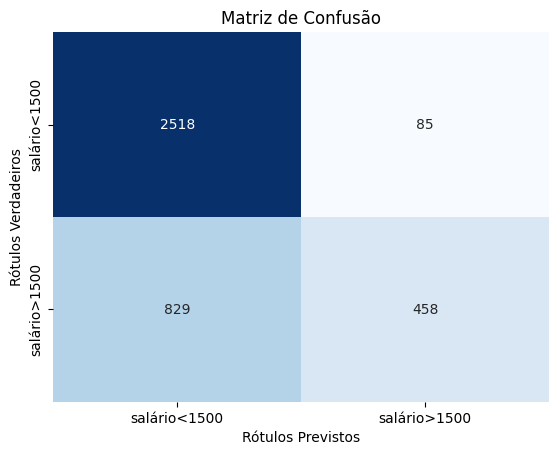

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_random_forest  = random_forest.predict(X_priv_invert)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_random_forest = accuracy_score(y_test_priv, y_pred_random_forest )
print(f'Acurácia do modelo: {acuracia_random_forest:.2f}')
print(classification_report(y_test_priv, y_pred_random_forest ))

# Calcular a matriz de confusão
cm_inv = confusion_matrix(y_test_priv, y_pred_random_forest)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm_inv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()





*   Métrica de Fairness - Disparate Impact



In [ ]:
# Calcula o disparate impact P_desp/P_priv
disparate_impact = (cm_inv[0][1]+cm_inv[1][1]) / (cm[0][1]+cm[1][1])
print("Disparate Impact:", disparate_impact)

# Interpretação: valores abaixo de 0.8 podem indicar disparidade

Disparate Impact: 0.6448931116389549




*   Métrica de Fairness - Igualdade de Oportunidade (Equal Opportunity)





In [ ]:
import numpy as np

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo protegido (a=1)
TP_privilegiado = cm[1][1]
FN_privilegiado = cm[1][0]
TPR_privilegiado = TP_privilegiado / (TP_privilegiado + FN_privilegiado)

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo não protegido (a=0)
TP_nao_privilegiado = cm_inv[1][1]
FN_nao_privilegiado = cm_inv[1][0]
TPR_nao_privilegiado = TP_nao_privilegiado / (TP_nao_privilegiado + FN_nao_privilegiado)

# Calculando a diferença na TPR entre os grupos
equal_opportunity_regressao_logistica = TPR_privilegiado - TPR_nao_privilegiado

print(f'Diferença de Equal Opportunity Regressao logistica: {equal_opportunity_regressao_logistica:.4f}')


Diferença de Equal Opportunity Regressao logistica: 0.1663


## XGB Classifier

*   Grupo Privilegiado (rótulo = 1)

Acurácia do modelo: 0.80
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      2603
         1.0       0.74      0.62      0.68      1287

    accuracy                           0.80      3890
   macro avg       0.78      0.76      0.77      3890
weighted avg       0.80      0.80      0.80      3890



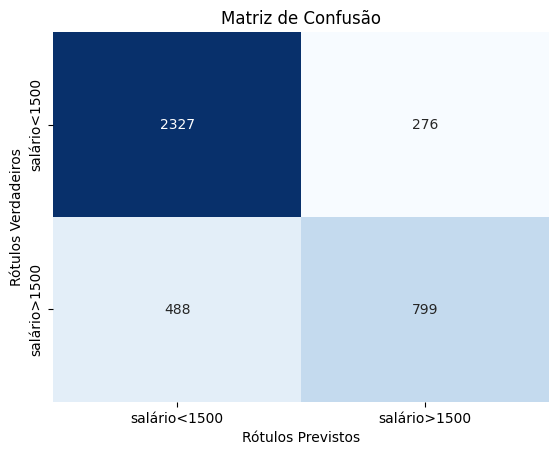

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_xgb_classifier  = xgb_classifier.predict(X_test_priv)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_xgb_classifier = accuracy_score(y_test_priv, y_pred_xgb_classifier)
print(f'Acurácia do modelo: {acuracia_xgb_classifier:.2f}')
print(classification_report(y_test_priv, y_pred_xgb_classifier ))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_priv, y_pred_xgb_classifier)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

*   Grupo Desprivilegiado (rótulo = 0)

Acurácia do modelo: 0.75
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83      2603
         1.0       0.68      0.46      0.55      1287

    accuracy                           0.75      3890
   macro avg       0.72      0.68      0.69      3890
weighted avg       0.74      0.75      0.74      3890



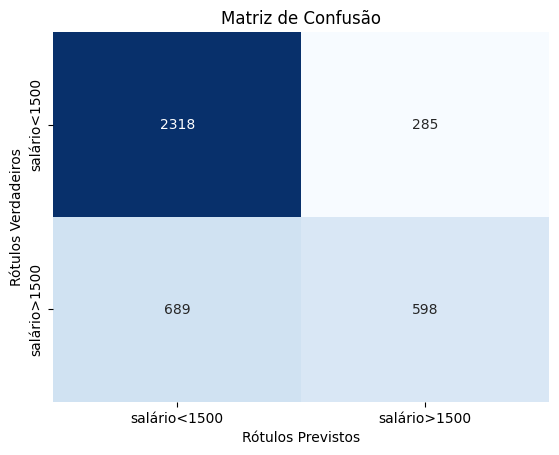

In [ ]:
# Fazer previsões usando os dados de teste
y_pred_xgb_classifier  = xgb_classifier.predict(X_priv_invert)

# Calcular a acurácia do modelo e imprimir o relatório de classificação
acuracia_xgb_classifier = accuracy_score(y_test_priv, y_pred_xgb_classifier )
print(f'Acurácia do modelo: {acuracia_xgb_classifier:.2f}')
print(classification_report(y_test_priv, y_pred_xgb_classifier ))

# Calcular a matriz de confusão
cm_inv = confusion_matrix(y_test_priv, y_pred_xgb_classifier)

# Criar a matriz de confusão decorada usando seaborn
sns.heatmap(cm_inv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['salário<1500', 'salário>1500'],
            yticklabels=['salário<1500', 'salário>1500'])
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()





*   Métrica de Fairness - Disparate Impact



In [ ]:
# Calcula o disparate impact P_desp/P_priv
disparate_impact = (cm_inv[0][1]+cm_inv[1][1]) / (cm[0][1]+cm[1][1])
print("Disparate Impact:", disparate_impact)

# Interpretação: valores abaixo de 0.8 podem indicar disparidade

Disparate Impact: 0.8213953488372093




*   Métrica de Fairness - Igualdade de Oportunidade (Equal Opportunity)





In [ ]:
import numpy as np

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo protegido (a=1)
TP_privilegiado = cm[1][1]
FN_privilegiado = cm[1][0]
TPR_privilegiado = TP_privilegiado / (TP_privilegiado + FN_privilegiado)

# Calculando a taxa de verdadeiros positivos (TPR) para o grupo não protegido (a=0)
TP_nao_privilegiado = cm_inv[1][1]
FN_nao_privilegiado = cm_inv[1][0]
TPR_nao_privilegiado = TP_nao_privilegiado / (TP_nao_privilegiado + FN_nao_privilegiado)

# Calculando a diferença na TPR entre os grupos
equal_opportunity_regressao_logistica = TPR_privilegiado - TPR_nao_privilegiado

print(f'Diferença de Equal Opportunity Regressao logistica: {equal_opportunity_regressao_logistica:.4f}')


Diferença de Equal Opportunity Regressao logistica: 0.1562
